In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets 
from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

import activationsf

In [4]:
# Check tf version
!python -c 'import tensorflow as tf; print(tf.__version__)' 

2020-09-15 00:18:22.338365: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2.3.0


In [5]:
# Load CIFAR10 
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [6]:
# Wrap using tf.data for better performane
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [7]:
relu_cnn = Sequential([
  
  # VGG inspired model: 
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  tf.keras.layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0012)),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
])

relu_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy')
  
relu_cnn.summary()

print('\nTraining \n')
history_relu = relu_cnn.fit(x = x_train, y = y_train, batch_size = 128, epochs=20, validation_data=(x_test, y_test))

print('\nModel Evaluation \n')
relu_cnn.evaluate(x = x_test, y = y_test, batch_size=128)

print('\nSave the Model \n')
relu_cnn.save('saved_custom_model/relu_cnn') 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [8]:
!zip -r relu_lightmodel.zip ./saved_custom_model/relu_cnn
from google.colab import files
files.download('./relu_lightmodel.zip')

  adding: saved_custom_model/relu_cnn/ (stored 0%)
  adding: saved_custom_model/relu_cnn/saved_model.pb (deflated 90%)
  adding: saved_custom_model/relu_cnn/variables/ (stored 0%)
  adding: saved_custom_model/relu_cnn/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_custom_model/relu_cnn/variables/variables.index (deflated 73%)
  adding: saved_custom_model/relu_cnn/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
kwta_cnn = Sequential([
  
  # Same architecture, use KWTA instead of ELU
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.30, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kwta(ratio=0.30, name='kwta_5'),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
  
])

kwta_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy')


kwta_cnn.summary()

print('\n Train with ratio 0.30 until convergence \n')
history_kwta_es = kwta_cnn.fit(train.shuffle(1000).batch(128), epochs = 10, validation_data=(x_test, y_test))

print('\n Fine tune learned weights until ratio is equal to 0.15 \n')
history_kwta_ft = kwta_cnn.fit(train.shuffle(1000).batch(128), epochs = 30, validation_data=(x_test, y_test), callbacks=[activationsf.incremental_learning_withDecreasing_ratio(num_layers=5)])

print('\n Model Evaluation \n')
kwta_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

print('\n Save the Model \n')
kwta_cnn.save('saved_custom_model/kwta_cnn') 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kwta_1 (Kwta)                (None, 32, 32, 32)        1         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kwta_2 (Kwta)                (None, 32, 32, 32)        1         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)       

In [10]:
!zip -r kwta_lightmodel.zip ./saved_custom_model/kwta_cnn
from google.colab import files
files.download('./kwta_lightmodel.zip')

  adding: saved_custom_model/kwta_cnn/ (stored 0%)
  adding: saved_custom_model/kwta_cnn/saved_model.pb (deflated 90%)
  adding: saved_custom_model/kwta_cnn/variables/ (stored 0%)
  adding: saved_custom_model/kwta_cnn/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_custom_model/kwta_cnn/variables/variables.index (deflated 72%)
  adding: saved_custom_model/kwta_cnn/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_1 (Kaf)                  (None, 32, 32, 32)        528       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
__________________________

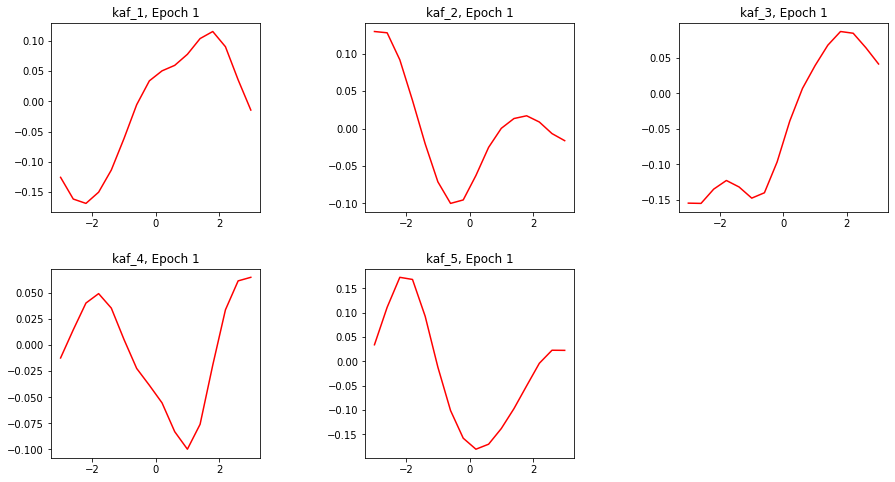

Epoch 1/20
391/391 [==============================] - 35s 91ms/step - loss: 1.8281 - sparse_categorical_accuracy: 0.3158 - val_loss: 2.1115 - val_sparse_categorical_accuracy: 0.2652


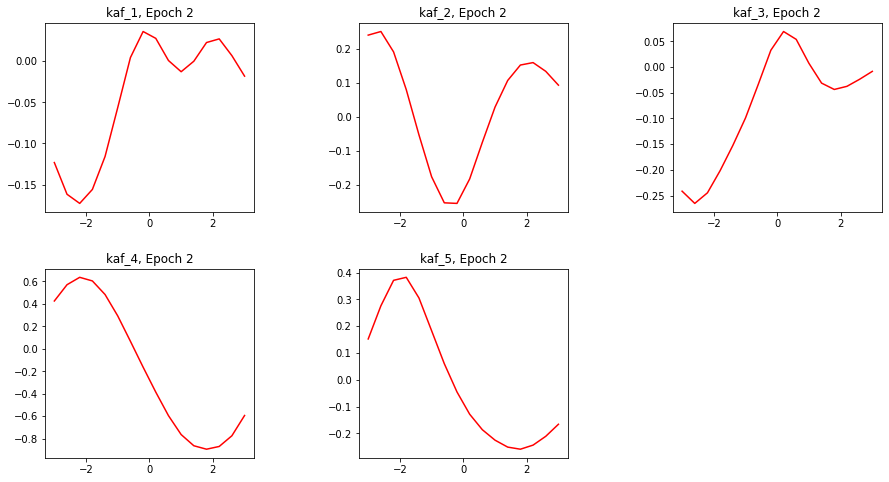

Epoch 2/20
391/391 [==============================] - 35s 90ms/step - loss: 1.3505 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.6538 - val_sparse_categorical_accuracy: 0.4528


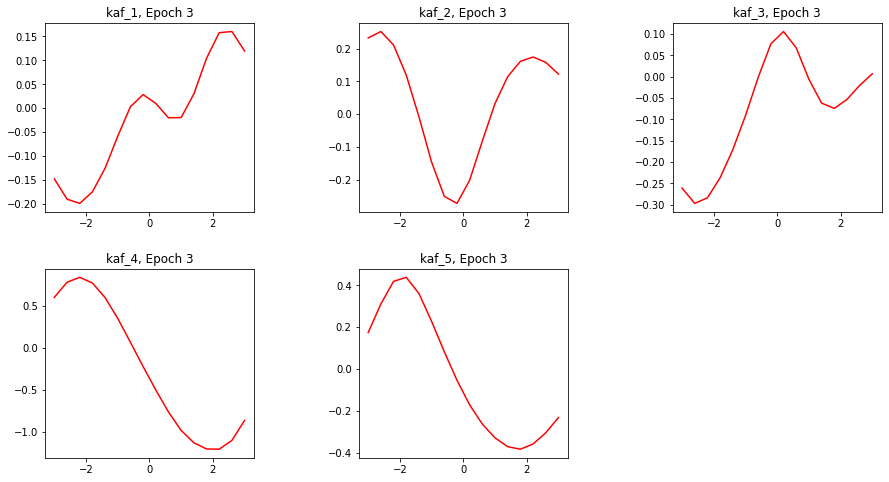

Epoch 3/20
391/391 [==============================] - 35s 90ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.2414 - val_sparse_categorical_accuracy: 0.5691


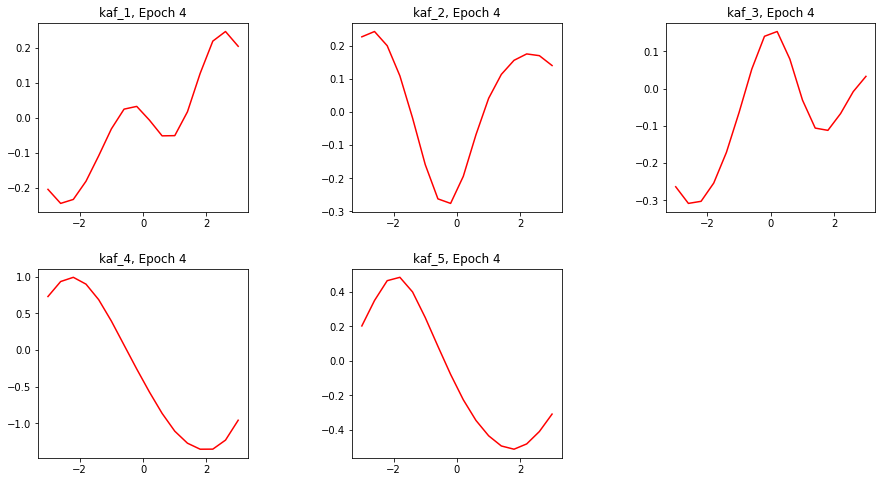

Epoch 4/20
391/391 [==============================] - 35s 90ms/step - loss: 1.0721 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.0726 - val_sparse_categorical_accuracy: 0.6315


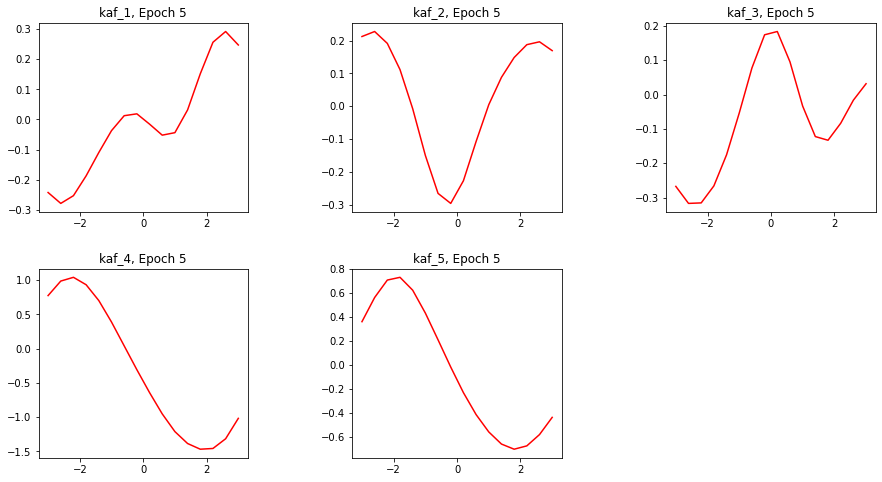

Epoch 5/20
391/391 [==============================] - 35s 90ms/step - loss: 0.9979 - sparse_categorical_accuracy: 0.6625 - val_loss: 1.1804 - val_sparse_categorical_accuracy: 0.6102


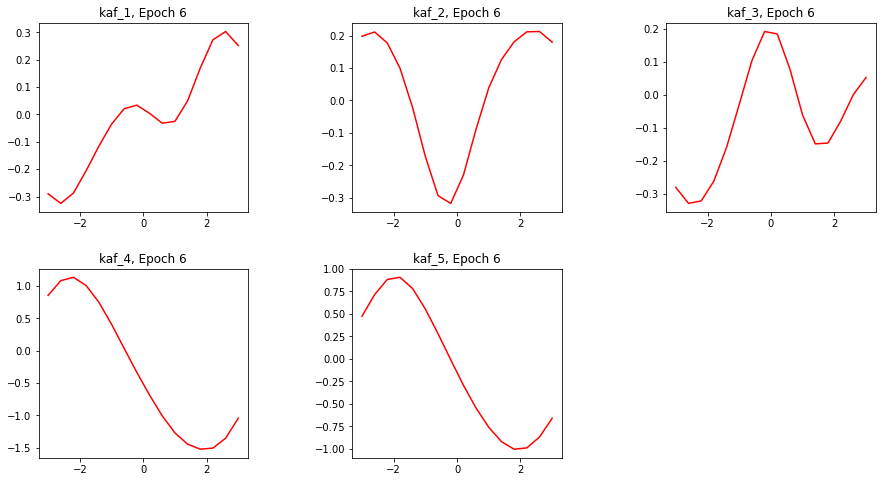

Epoch 6/20
391/391 [==============================] - 35s 91ms/step - loss: 0.9474 - sparse_categorical_accuracy: 0.6798 - val_loss: 1.2836 - val_sparse_categorical_accuracy: 0.5850


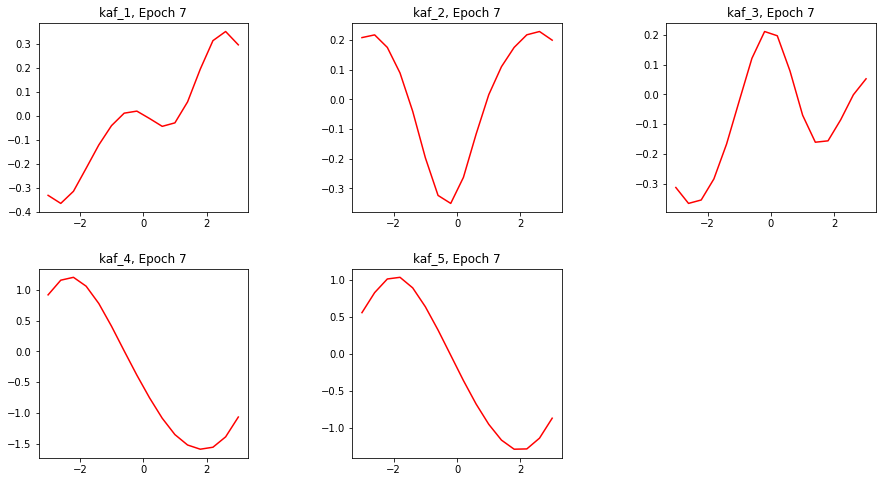

Epoch 7/20
391/391 [==============================] - 35s 90ms/step - loss: 0.8996 - sparse_categorical_accuracy: 0.6983 - val_loss: 1.0705 - val_sparse_categorical_accuracy: 0.6523


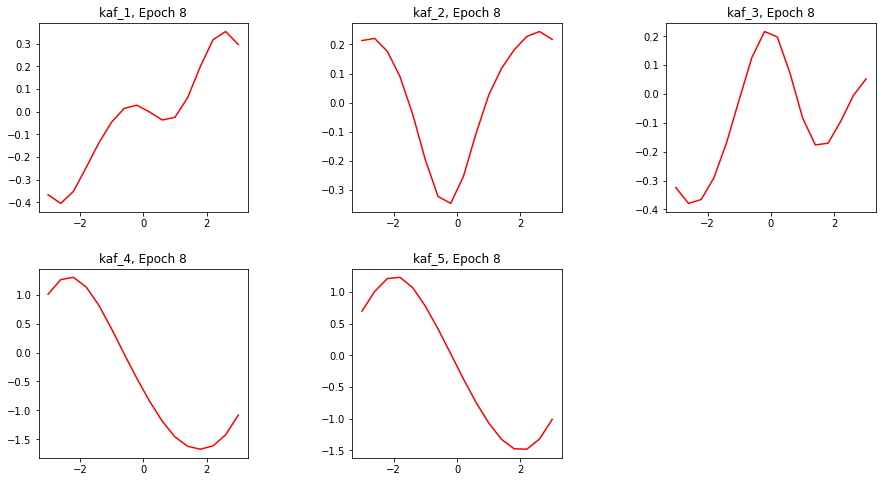

Epoch 8/20
391/391 [==============================] - 35s 90ms/step - loss: 0.8697 - sparse_categorical_accuracy: 0.7085 - val_loss: 1.0284 - val_sparse_categorical_accuracy: 0.6555


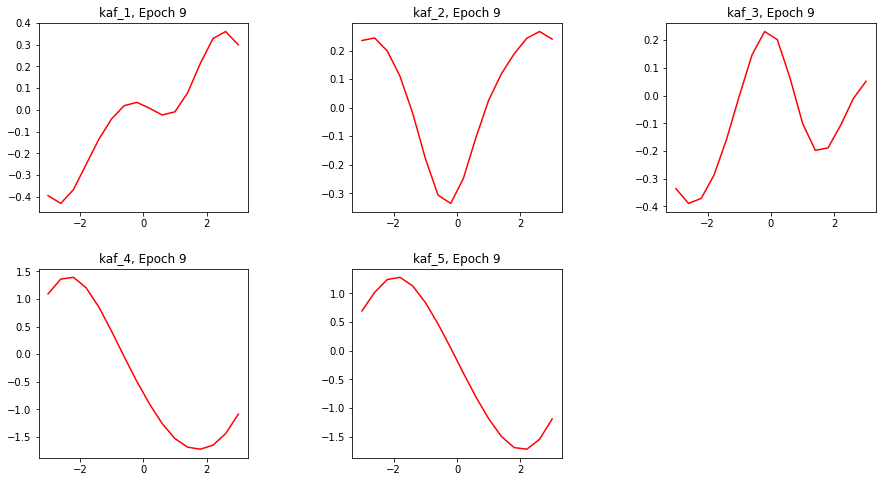

Epoch 9/20
391/391 [==============================] - 35s 90ms/step - loss: 0.8387 - sparse_categorical_accuracy: 0.7202 - val_loss: 1.2193 - val_sparse_categorical_accuracy: 0.6128


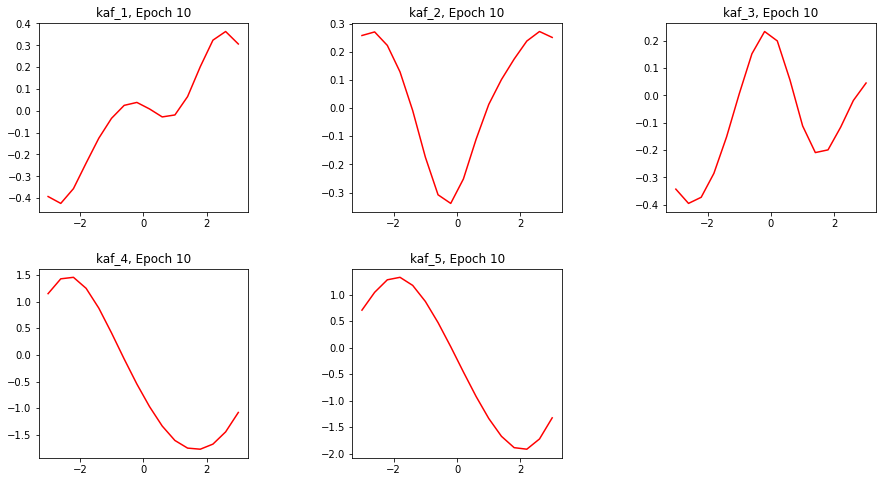

Epoch 10/20
391/391 [==============================] - 35s 90ms/step - loss: 0.8183 - sparse_categorical_accuracy: 0.7268 - val_loss: 1.0990 - val_sparse_categorical_accuracy: 0.6373


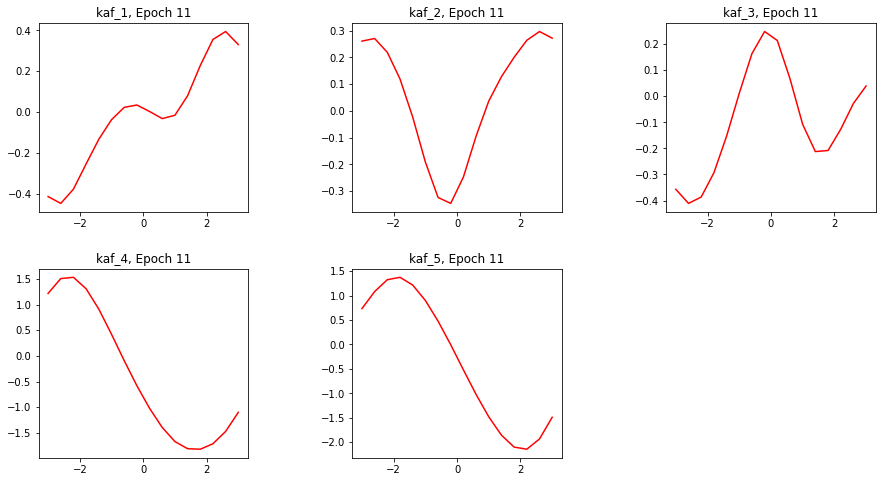

Epoch 11/20
391/391 [==============================] - 35s 90ms/step - loss: 0.7905 - sparse_categorical_accuracy: 0.7359 - val_loss: 1.0050 - val_sparse_categorical_accuracy: 0.6617


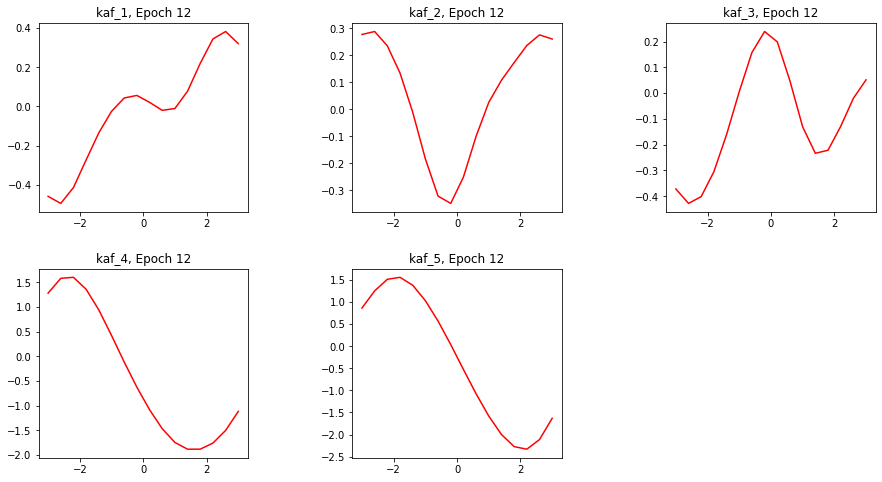

Epoch 12/20
391/391 [==============================] - 35s 90ms/step - loss: 0.7745 - sparse_categorical_accuracy: 0.7422 - val_loss: 1.6205 - val_sparse_categorical_accuracy: 0.5294


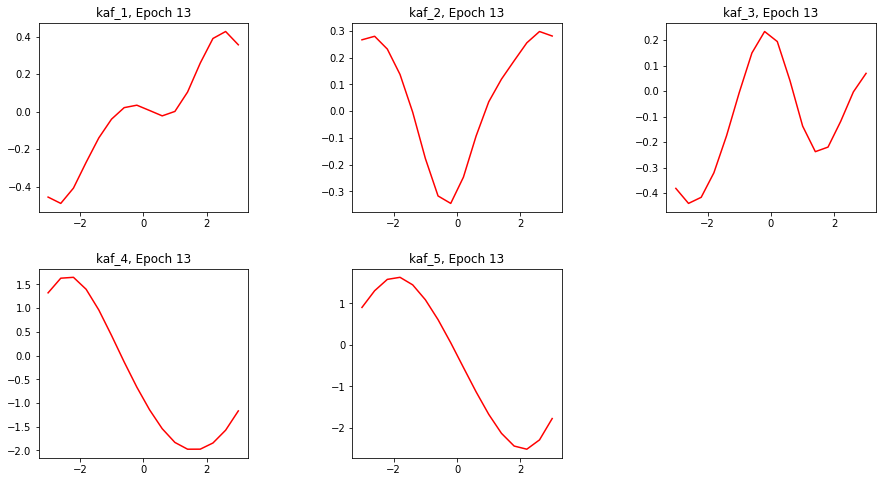

Epoch 13/20
391/391 [==============================] - 35s 90ms/step - loss: 0.7563 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9370 - val_sparse_categorical_accuracy: 0.6887


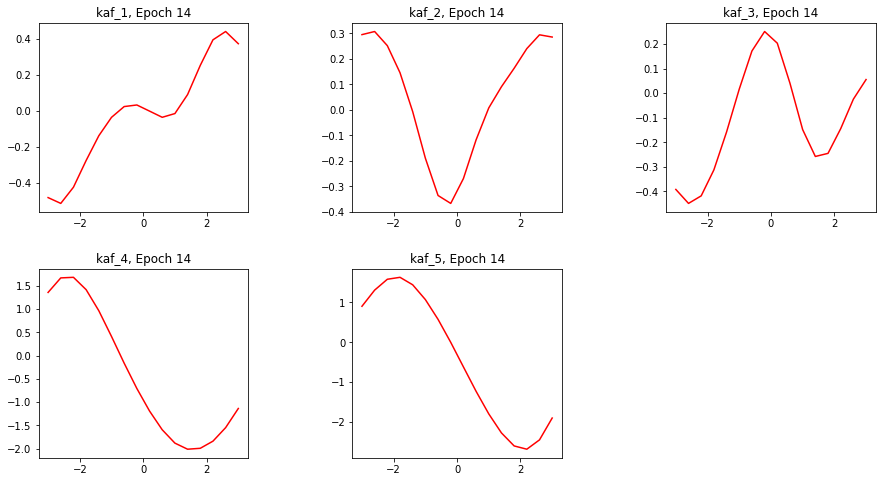

Epoch 14/20
391/391 [==============================] - 35s 91ms/step - loss: 0.7372 - sparse_categorical_accuracy: 0.7569 - val_loss: 1.0311 - val_sparse_categorical_accuracy: 0.6525


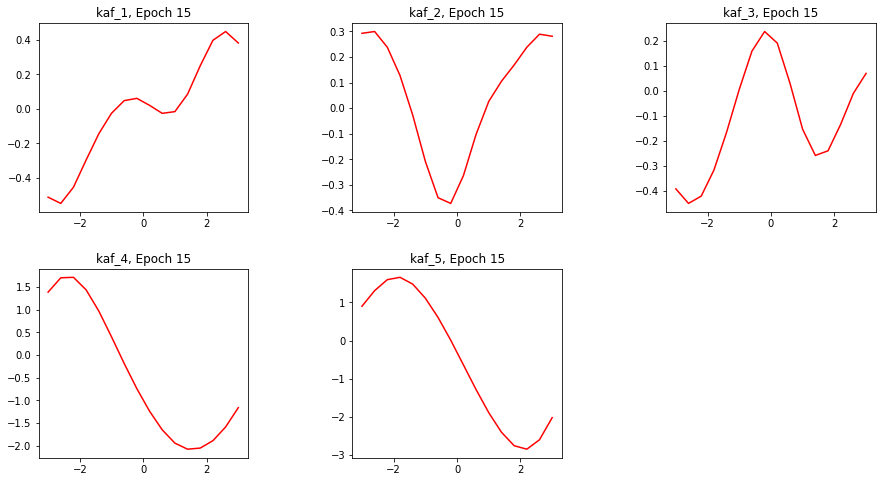

Epoch 15/20
391/391 [==============================] - 35s 90ms/step - loss: 0.7222 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.6929


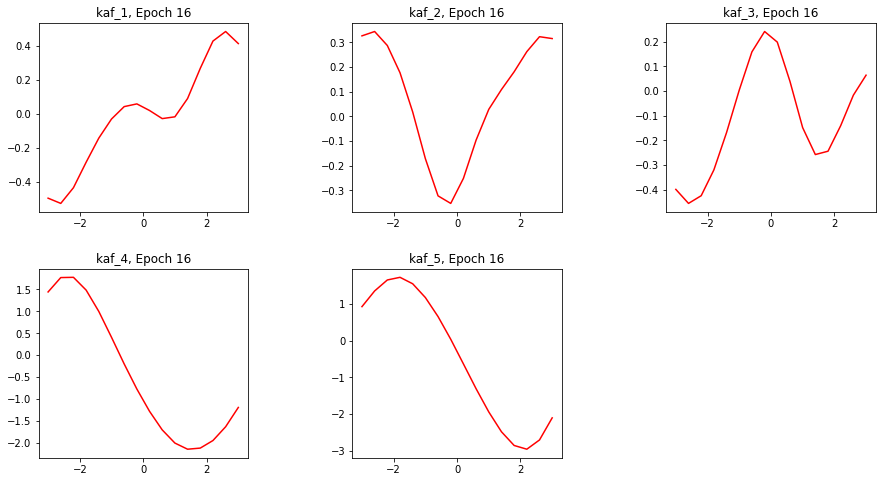

Epoch 16/20
391/391 [==============================] - 35s 90ms/step - loss: 0.7069 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.9575 - val_sparse_categorical_accuracy: 0.6861


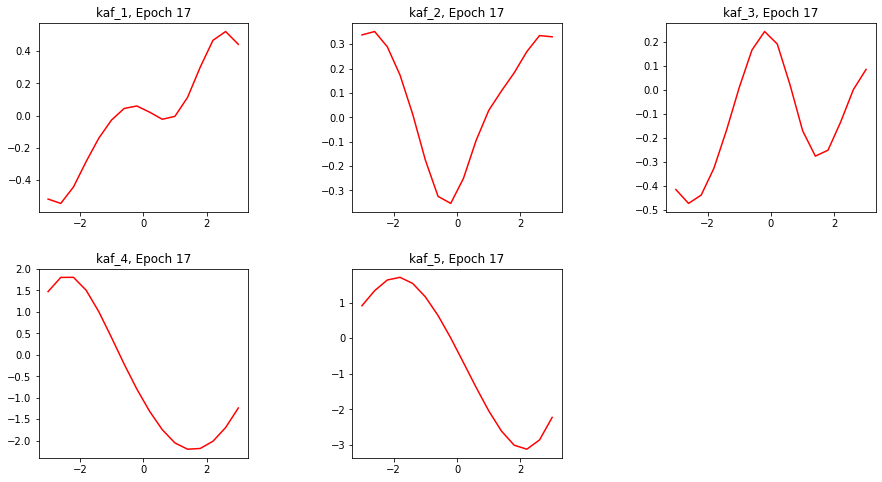

Epoch 17/20
391/391 [==============================] - 35s 90ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.9535 - val_sparse_categorical_accuracy: 0.6950


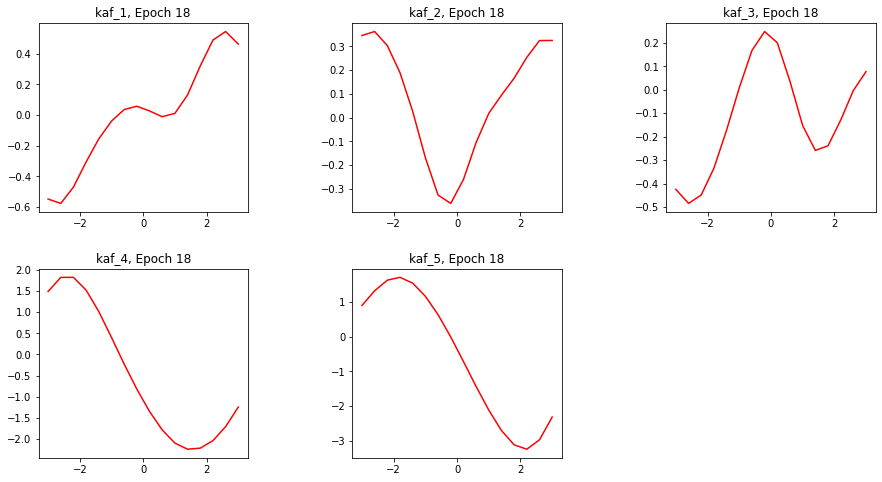

Epoch 18/20
391/391 [==============================] - 35s 90ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.7768 - val_loss: 1.0295 - val_sparse_categorical_accuracy: 0.6634


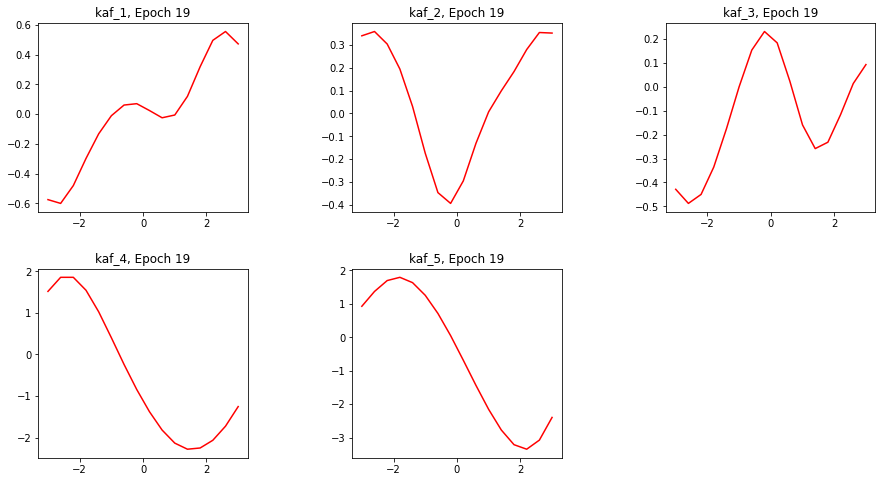

Epoch 19/20
391/391 [==============================] - 35s 91ms/step - loss: 0.6715 - sparse_categorical_accuracy: 0.7793 - val_loss: 1.0308 - val_sparse_categorical_accuracy: 0.6705


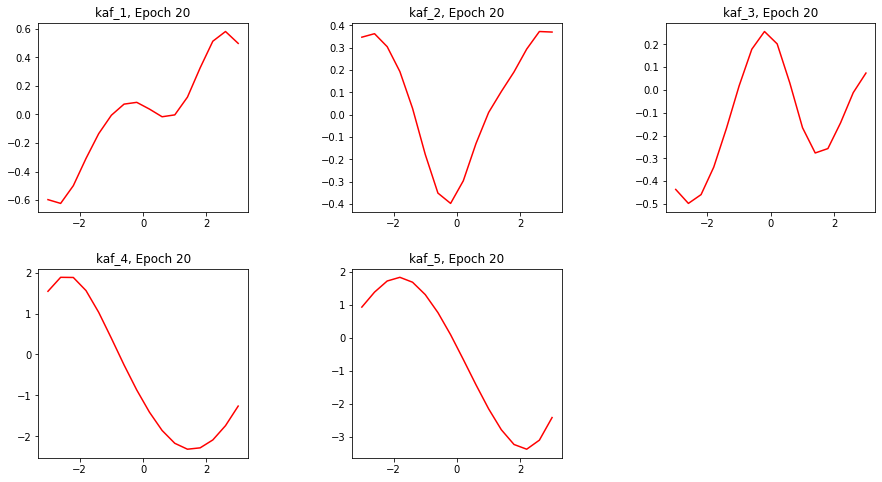

Epoch 20/20
79/79 [==============================] - 2s 27ms/step - loss: 0.9387 - sparse_categorical_accuracy: 0.6880
INFO:tensorflow:Assets written to: saved_custom_model/kaf_cnn/assets


In [11]:
# Might speed up training casting computation to tf.float16.
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

kaf_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=16, name='kaf_5'),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

kaf_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics='sparse_categorical_accuracy')

kaf_cnn.summary()

# Train until convergence
history_kaf = kaf_cnn.fit(train.shuffle(1000).batch(128), epochs = 20, validation_data=(x_test, y_test), callbacks=[activationsf.plot_kafs_epoch_wise(num_layers=5)])
#summarize_diagnostics(history_kaf)

kaf_cnn.evaluate(x = x_test, y = y_test, batch_size=128)

# Save kaf_cnn
kaf_cnn.save('saved_custom_model/kaf_cnn')

In [12]:
!zip -r kaf_lightmodel.zip ./saved_custom_model/kaf_cnn
from google.colab import files
files.download('./kaf_lightmodel.zip')

  adding: saved_custom_model/kaf_cnn/ (stored 0%)
  adding: saved_custom_model/kaf_cnn/saved_model.pb (deflated 90%)
  adding: saved_custom_model/kaf_cnn/variables/ (stored 0%)
  adding: saved_custom_model/kaf_cnn/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_custom_model/kaf_cnn/variables/variables.index (deflated 73%)
  adding: saved_custom_model/kaf_cnn/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>